In [67]:
import pandas as pd
import seaborn as sns
import sys
import os

# add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from lib.functions import *

In [68]:
df = pd.read_csv("../data/diabetes_prediction_dataset.csv")

### Data Cleaning

In [69]:
# drop rows
df=df.loc[df['smoking_history'] != 'No Info']
df=df.loc[df['gender'] != 'Other']

# aggregate values
df['smoking_history'].loc[df["smoking_history"] == 'not current'] = 'former'

<Axes: xlabel='smoking_history', ylabel='count'>

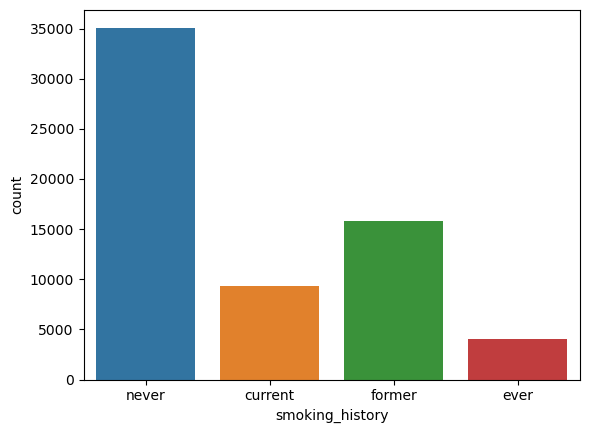

In [70]:
sns.countplot(df, x='smoking_history')

<Axes: xlabel='HbA1c_level', ylabel='count'>

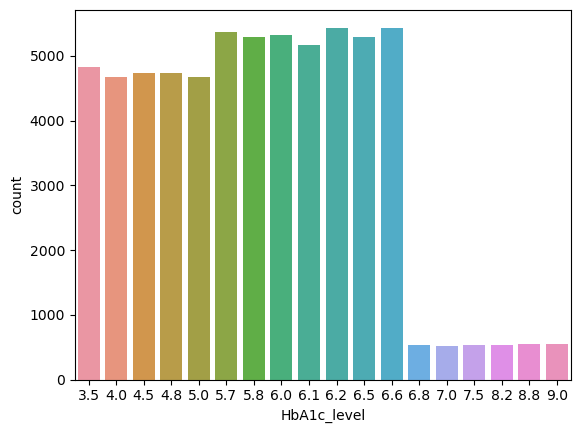

In [71]:
sns.countplot(df, x='HbA1c_level')

<Axes: xlabel='bmi', ylabel='Count'>

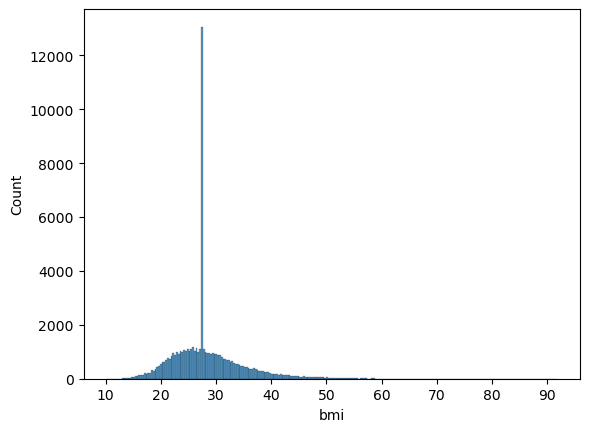

In [72]:
sns.histplot(df, x='bmi')

In [83]:
df.loc[df['bmi'] == 27.32].shape

(12045, 9)

In [84]:
df = df.loc[df['bmi'] != 27.32]

In [85]:
df['bmi'].describe()

count    52127.000000
mean        28.679424
std          7.205693
min         10.080000
25%         23.650000
50%         27.620000
75%         32.480000
max         91.820000
Name: bmi, dtype: float64

<Axes: xlabel='blood_glucose_level', ylabel='count'>

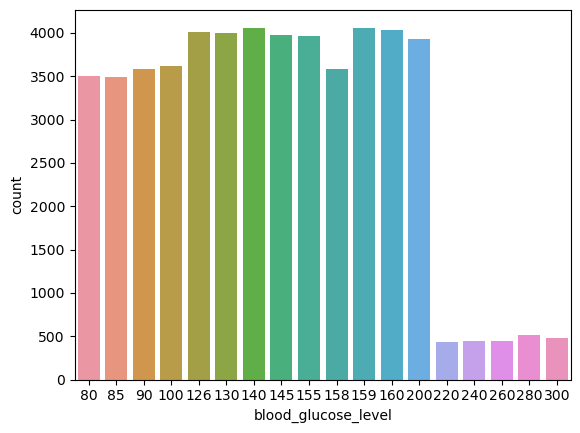

In [86]:
sns.countplot(df, x='blood_glucose_level')

<Axes: xlabel='age', ylabel='Count'>

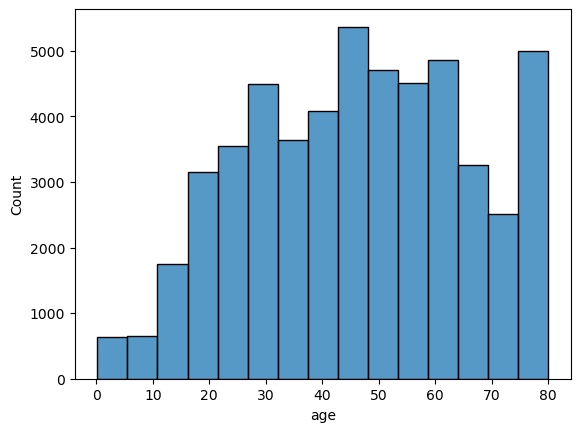

In [87]:
sns.histplot(df, x='age', bins=15)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52127 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               52127 non-null  object 
 1   age                  52127 non-null  float64
 2   hypertension         52127 non-null  int64  
 3   heart_disease        52127 non-null  int64  
 4   smoking_history      52127 non-null  object 
 5   bmi                  52127 non-null  float64
 6   HbA1c_level          52127 non-null  float64
 7   blood_glucose_level  52127 non-null  int64  
 8   diabetes             52127 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 4.0+ MB


### Feature Engineering

In [89]:
# transform categorical columns to numerical
df["smoking_history"] = df["smoking_history"].map({'never': 0, 'former': 1, 'current': 2, 'ever': 3})
df = pd.get_dummies(df, columns=['gender'])

In [90]:
df.head(3)

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male
0,80.0,0,1,0,25.19,6.6,140,0,1,0
3,36.0,0,0,2,23.45,5.0,155,0,1,0
4,76.0,1,1,2,20.14,4.8,155,0,0,1


<Axes: >

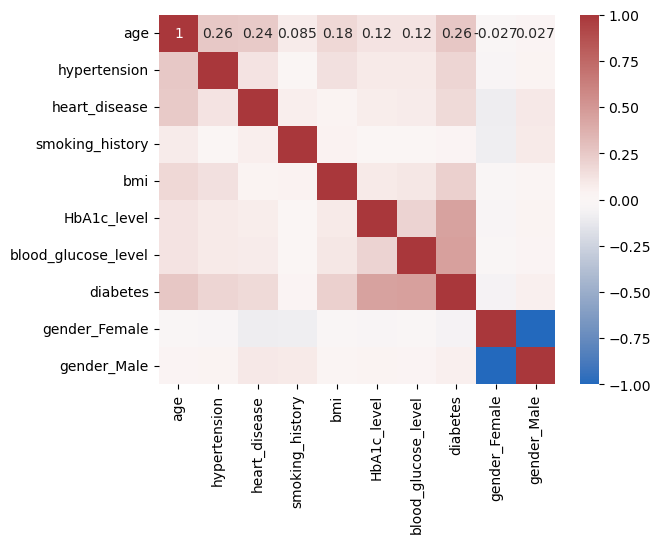

In [121]:
df_corr = df.corr()
sns.heatmap(df_corr, cmap = 'vlag', vmin = -1, vmax = 1, annot=True)

In [91]:
# define features and target
features = df.drop(columns = ["diabetes"])
target = df["diabetes"]

In [96]:
# split data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

In [97]:
# normalize features

from sklearn.preprocessing import MinMaxScaler, StandardScaler
#normalizer = MinMaxScaler()
normalizer = StandardScaler()

X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

pd.DataFrame(X_train_norm).head(3)

,0,1,2,3,4,5,6,7,8
0,0.072461,-0.343277,-0.228601,-0.761488,-0.348444,0.203419,-1.289744,0.795912,-0.795912
1,-0.438687,-0.343277,-0.228601,-0.761488,-0.366506,0.203419,-1.172409,0.795912,-0.795912
2,-0.592031,-0.343277,-0.228601,-0.761488,-0.062230,0.931687,1.408965,0.795912,-0.795912


### Model Training and Evaluation

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Define models
models = {
  'Random Forest 20': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42),
  'Random Forest 30': RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42),
  'KNN': KNeighborsClassifier(),
  'Logistic Regression': LogisticRegression(),
}

# Train and evaluate models
results = {}
accuracy = {}
recall = {}
precision = {}

for name, model in models.items():
  # Train the model
  model.fit(X_train_norm, y_train)
  
  # Make predictions
  y_pred = model.predict(X_test_norm)
  
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)

  # Calculate recall/sensitivity [tp / (tp + fn)]
  sensitivity = recall_score(y_test, y_pred)

  # Calculate specificity  [tn / (tn + fp)]
  specificity = recall_score(y_test, y_pred, pos_label=0)

  # Calculate precision [tp / (tp + fp)]
  precision = precision_score(y_test, y_pred)
  
  # Store results
  results[name] = {'accuracy': accuracy, 'sensitivity': sensitivity, 'specificity': specificity, 'precision': precision}

for name, result in results.items():
    print(f'{name} \naccuracy: {round(result["accuracy"], 3)} \nsensitivity: {round(result["sensitivity"], 3)} \nspecificity: {round(result["specificity"], 3)} \nprecision: {round(result["precision"], 3)}')
    print('')

Random Forest 20 
accuracy: 0.961 
sensitivity: 0.695 
specificity: 0.995 
precision: 0.949

Random Forest 30 
accuracy: 0.961 
sensitivity: 0.699 
specificity: 0.994 
precision: 0.939

KNN 
accuracy: 0.947 
sensitivity: 0.623 
specificity: 0.989 
precision: 0.874

Logistic Regression 
accuracy: 0.947 
sensitivity: 0.645 
specificity: 0.985 
precision: 0.847



In [110]:
# total share of positives in the dataset
df['diabetes'].value_counts()[1] / (df['diabetes'].value_counts()[0] + df['diabetes'].value_counts()[1])
# tp / (tp + fp)

0.1160626930381568

To-dos:
* Cross Validation
* Correlation test
* dummies for 'smoking history'
* PCA
* Outliers
* other KPIs? (MSE, ...)

Questions:
* Outliers
* Correlation in columns after one hot encoding
* Encoding of smoking history
* Heatmap values
* Workflow
    * Corrlation check before or after normalization?